# Townsend function (modified) - One constraint

This is a GPyOpt contrained optimization example for the [Townsend function with heart constraint](https://en.wikipedia.org/wiki/Test_functions_for_optimization). There is an isolated globalm minimum:

$f(2.0052938,1.1944509) = -2.0239884$

The important imports are the [GPy](https://sheffieldml.github.io/GPy/) and [GPyOpt](https://github.com/SheffieldML/GPyOpt) libraries, and the initial_design function to select the first points to initialize the method. This function requires dealing with constraint, which is done using the acquisition function of [Expected Improvement](https://www.researchgate.net/publication/248818761_The_application_of_Bayesian_methods_for_seeking_the_extremum) (EI) with [Probability of Feasibility](https://dl.acm.org/citation.cfm?id=3044997) (PoF). For references of Probability of Feasibility, read [Gardner et. al. (2014)](https://stat.columbia.edu/~cunningham/pdf/GardnerICML2014.pdf), [Gelbart (2015)](https://dash.harvard.edu/bitstream/handle/1/17467236/GELBART-DISSERTATION-2015.pdf?sequence=4&isAllowed=y) and [Schonlau (2015)](https://www.collectionscanada.gc.ca/obj/s4/f2/dsk3/ftp04/nq22234.pdf). A modified version of the Bayesian Optimization method is required, named ModularConstrainedBayesianOptimization.

In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.EI_PoF import AcquisitionEI_PoF
from GPyOpt.methods import ModularConstrainedBayesianOptimization

Populating the interactive namespace from numpy and matplotlib


The definition of the Townsend function, with heart constraint, is given by the functions below:

In [2]:
def townsend(x,y):
    f1 = np.cos((x-0.1)*y)
    f2 = x*np.sin(3.*x+y)
    return -(f1**2+f2)

def heart_constraint(x,y):
    t = np.arctan2(x,y)
    r1 = 2.*np.cos(t)-0.5*np.cos(2.*t)-0.25*np.cos(3.*t)-0.125*np.cos(4.*t)
    R2 = r1**2 + (2.*np.sin(t))**2
    return (R2-x**2-y**2)

Create (xv,yv) variables to be able to plot and visualize the function in 2D and 3D

In [3]:
X_ax = np.linspace(-2.25,2.5,201)
Y_ax = np.linspace(-2.5,1.75,201)

xv, yv = np.meshgrid(X_ax, Y_ax, sparse=False, indexing='ij')

zv = np.zeros(xv.shape)

for i in range(X_ax.shape[0]):
    for j in range(Y_ax.shape[0]):
        g1 = heart_constraint(X_ax[i],Y_ax[j])
        if( (g1>=0) ):
            zv[i,j] = townsend(X_ax[i],Y_ax[j])
        else:
            zv[i,j] = np.nan

To the left, the 2D heatmap plot of the Townsend function, and to the right, a 3D rendering of the same function. There is an isolated global minimum.

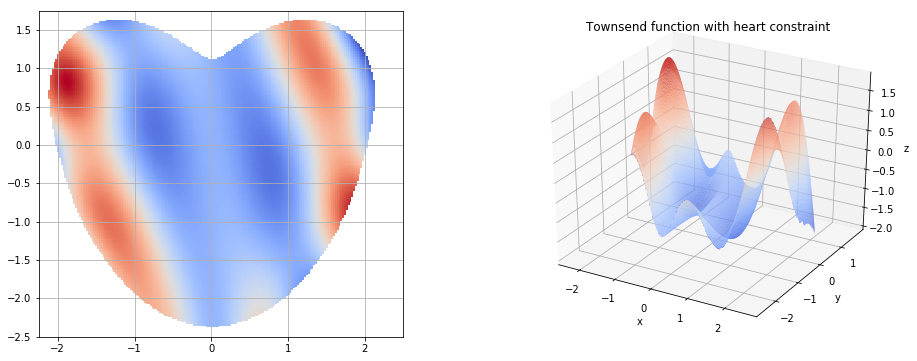

In [4]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
ax.grid()
ax.imshow(zv.T,cmap=cm.coolwarm,extent=(-2.25,2.5,-2.5,1.75),origin='bottom')

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(xv, yv, zv, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none',
                vmin = -2, vmax = 2)

ax2.set_title('Townsend function with heart constraint');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
plt.show()

The search space of the optimization problem is the box $[-2.25,2.5] \times [-2.5,1.75]$, with continuous variables.

There are tree GP models: One for interpolating the objective function, and another two for interpolating the constraints. In this case the constraints are very simple,but it might not be the case in other problems.

The acquisition function is the Expected Improvement with Probability of Feasibility extension, named AcquisitionEI_PoF. The evaluator is the standard serial evaluator. jitter is set to $10^{-3}$

The initial choice of points is done via the initial_design function, according to a [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) sampling. The objective function and the constraints are evaluated on those points before the Bayesian optimization loop. 

In [5]:
np.set_printoptions(precision=6)

objective = None 
constraint = None

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-2.25,2.5)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-2.5,1.75)}]
space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model    = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

acquisition = AcquisitionEI_PoF(model,model_c,space,optimizer=aquisition_optimizer)

# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

num_init = 20
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],1))
C_init = np.zeros((X_init.shape[0],1))

for i in range(num_init):
    Y_init[i,0] = townsend(X_init[i,0],X_init[i,1])
    C_init[i,0] = heart_constraint(X_init[i,0],X_init[i,1])
    
print(np.hstack((X_init,Y_init,C_init)))

[[-2.13125  -1.33125  -3.084509 -2.413027]
 [-1.65625   0.79375   1.391874  1.976048]
 [-0.94375  -1.54375   0.888905  1.349222]
 [ 0.48125  -1.11875  -0.982513  3.501548]
 [-1.18125   0.15625  -0.672895  3.048835]
 [-0.23125   1.43125  -0.63607  -0.61263 ]
 [ 1.19375  -0.90625  -0.836954  1.732217]
 [ 0.71875  -0.69375  -1.54132   3.124922]
 [ 2.14375  -0.26875  -0.469368 -0.728585]
 [ 0.24375   1.00625  -1.219593  0.681056]
 [-0.46875  -0.05625  -1.464981  3.722712]
 [ 0.95625   1.64375   0.910768 -0.20861 ]
 [-1.41875  -2.39375  -1.284077 -3.086443]
 [ 2.38125   0.36875  -2.688059 -1.273206]
 [-1.89375   1.21875   1.261508  0.377921]
 [-0.70625  -2.18125   0.612173 -0.039701]
 [ 1.90625  -1.96875   0.251704 -3.335526]
 [ 1.43125  -1.75625  -1.29479  -0.807315]
 [ 0.00625  -0.48125  -0.995177  5.408157]
 [ 1.66875   0.58125   0.694616  1.96312 ]]


The main external loop is executed using the ModularConstrainedBayesianOptimization object, initialized with the interpolation method of usual Gaussian Process, the acquisition function is the Expected Improvement w/ PoF, and default jitter used for a standard Bayesian Optimization loop.

In [6]:
iter_count = 120-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:
    bo_step = ModularConstrainedBayesianOptimization(model,
                                                     model_c,
                                                     space,
                                                     objective,
                                                     constraint,
                                                     acquisition,
                                                     evaluator,
                                                     X_init = X_step,
                                                     Y_init = Y_step,
                                                     C_init = C_step, 
                                                     normalize_Y = False)
    x_next = bo_step.suggest_next_locations()
    y_next = np.array(townsend(x_next[0][0],x_next[0][1]))
    c1_next = heart_constraint(x_next[0][0],x_next[0][1])
    c_next = np.array([c1_next])
    print("Current iteration - ",current_iter," : ",x_next,y_next,c_next)
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

Current iteration -  0  :  [[-0.102001  0.41443 ]] -0.9819701221470891 [1.585701]
Current iteration -  1  :  [[-1.744726 -0.812165]] 0.4041150007419 [0.134645]
Current iteration -  2  :  [[ 1.043888 -1.507196]] -1.0641796075919583 [1.128304]
Current iteration -  3  :  [[ 0.55482  -0.341216]] -1.514014313147452 [3.472367]
Current iteration -  4  :  [[ 0.484354 -0.600047]] -1.3125936204289435 [3.740079]
Current iteration -  5  :  [[ 0.858691 -0.398697]] -1.6167605232419366 [2.941699]
Current iteration -  6  :  [[0.5492   0.192187]] -1.5220161695239072 [4.751234]
Current iteration -  7  :  [[ 0.746104 -0.087488]] -1.6208851429603441 [3.384571]
Current iteration -  8  :  [[2.5      0.906787]] -2.4515883329182557 [-1.950918]
Current iteration -  9  :  [[ 0.812046 -2.08046 ]] -0.2907478058189972 [0.084138]
Current iteration -  10  :  [[-0.689235  0.250433]] -1.6298456114895612 [4.585121]
Current iteration -  11  :  [[2.266678 0.449772]] -2.180774764727175 [-0.679072]
Current iteration -  12 

Summary of the improvement of the best found point:

In [7]:
X_val = X_step[np.all(C_step>=0,axis=1)]
Y_val = Y_step[np.all(C_step>=0,axis=1)]
C_val = C_step[np.all(C_step>=0,axis=1)]

A_val = np.hstack((X_val,Y_val,C_val))

T =  0.00
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -0.50
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -1.00
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -1.50
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -1.95
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
print(np.argmin(Y_val,axis=0)[0],X_val[np.argmin(Y_val,axis=0)][0],Y_val[np.argmin(Y_val,axis=0)][0])

2 [ 0.48125 -1.11875] [-0.982513]
2 [ 0.48125 -1.11875] [-0.982513]
5 [ 0.71875 -0.69375] [-1.54132]
5 [ 0.71875 -0.69375] [-1.54132]
39 [2.006376 1.173489] [-1.96538]
40 [1.972952 1.242036] [-1.987843]


Summary of the optimization: 

In [8]:
print("Point step where minimium was found: ",np.argmin(Y_step))
print("Exact Global minima: ")
print(np.array([2.0052938,1.1944509,-2.0239884]))
print("Global minima found: ")
print(np.hstack((X_val[Y_val[:,0]<-1.95,:],Y_val[Y_val<-1.95][:,np.newaxis])))

Point step where minimium was found:  0
Exact Global minima: 
[ 2.005294  1.194451 -2.023988]
Global minima found: 
[[ 2.006376  1.173489 -1.96538 ]
 [ 1.972952  1.242036 -1.987843]]


Plotting the heatmap of the Simionescu function against the scatterplot of the queried points, one obtains the picture below:

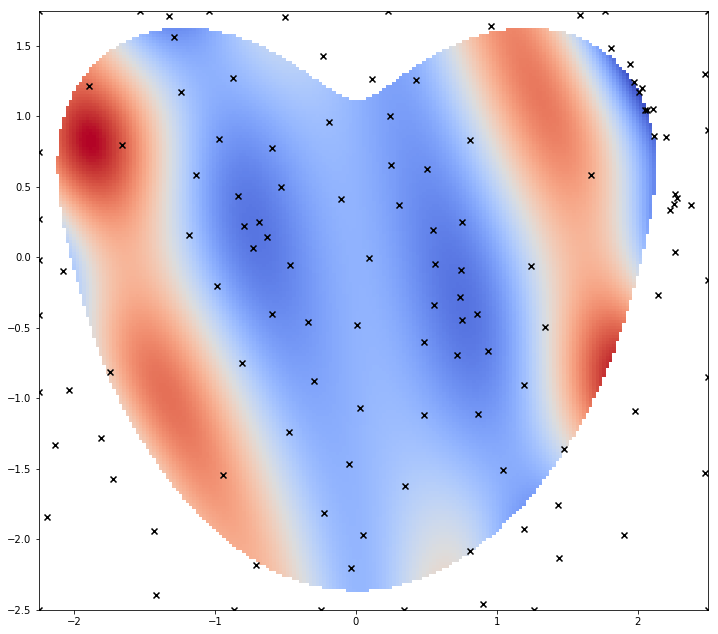

In [9]:
fig = plt.figure(figsize = (12,12))
ax.set_aspect('equal')

plt.imshow(zv.T,cmap=cm.coolwarm,extent=(-2.25,2.5,-2.5,1.75),origin='bottom')
plt.scatter(X_step[:,0],X_step[:,1],marker='x',color='black')

plt.xlim(-2.25,2.50)
plt.ylim(-2.50,1.75)

plt.show()

Creating a series of .jpg files so one can create a gif with the dynamic visualization of the Bayesian Optimization loop:

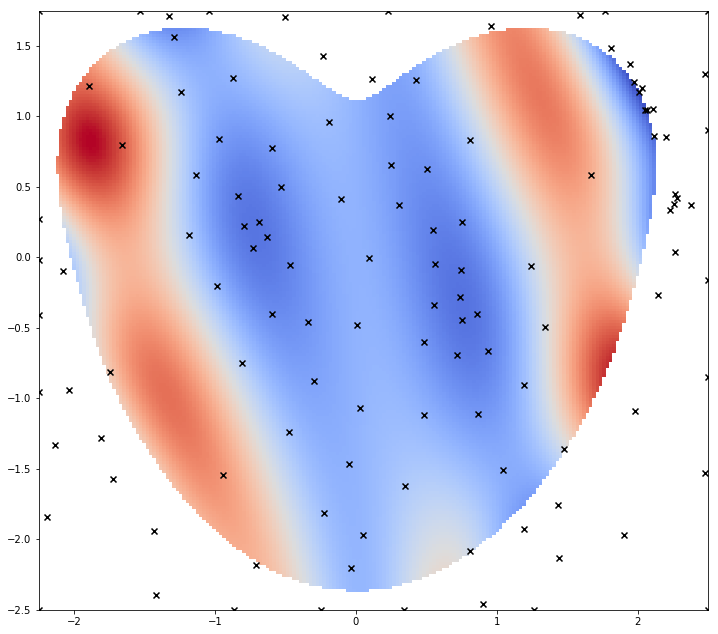

In [10]:
import os

if(not os.path.exists("gif")):
    os.mkdir("gif")

fig = plt.figure(figsize = (12,12))
plt.xlim((-2.25,2.50))
plt.ylim((-2.50,1.75))
for n in range(iter_count):
    fig.clf()
    plt.xlim((-2.25,2.50))
    plt.ylim((-2.50,1.75))
    plt.imshow(zv.T,cmap=cm.coolwarm,aspect ='equal',origin='lower',extent=(-2.25,2.50,-2.50,1.75))
    plt.scatter(X_step[0:(n+num_init),0],X_step[0:(n+num_init),1],c='black',marker='x')
    plt.savefig("gif/BO_Townsend-MC1-"+str(n)+"-("+typ_init+","+str(num_init)+").jpg", bbox_inches='tight')